# Individual phase prediction

In this notebook we evaluate different machine learning models in terms of their ability to predict indiviudal phase occurrences.



In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

STATE = np.random.RandomState(seed=1000)

## Data

In these experiments we only consider abstract predictor variables (fingerprints) and no concrete monomer type indicator variables.

In [2]:
import data1 as data
x = data.x.filter(data.predictors, axis=1)
x

,clogp_corona,mon_corona_mw,mon_corona_apol,mon_corona_mv,mon_corona_psa,dp_corona,corona_mw_total,corona_mv_total,clogp_core,mon_core_mw,...,dp_core,core_mw_total,core_mv_total,ratio_mass,ratio_vol,conc,ph,salt,charged,temp
Entry no,,,,,,,,,,,,,,,,,,,,,
1,0.09,160.07,23.529516,1.2437,66.76,56,8963.92,69.6472,1.10445,144.8997,...,181,26226.8457,215.354886,0.254724,0.244374,10.0,7.0,0.0,0,70
2,0.09,160.07,23.529516,1.2437,66.76,56,8963.92,69.6472,1.10445,144.8997,...,121,17532.8637,143.966526,0.338302,0.326043,10.0,7.0,0.0,0,70
3,0.09,160.07,23.529516,1.2437,66.76,56,8963.92,69.6472,1.10445,144.8997,...,161,23328.8517,191.558766,0.277583,0.266637,10.0,7.0,0.0,0,70
4,0.09,160.07,23.529516,1.2437,66.76,56,8963.92,69.6472,1.10445,144.8997,...,201,29124.8397,239.151006,0.235343,0.225543,10.0,7.0,0.0,0,70
5,0.09,160.07,23.529516,1.2437,66.76,56,8963.92,69.6472,1.10445,144.8997,...,261,37818.8217,310.539366,0.191607,0.183192,10.0,7.0,0.0,0,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,0.34,143.09,23.692309,1.2261,49.33,41,5866.69,50.2701,1.10000,144.0800,...,180,25934.4000,213.300000,0.184481,0.190728,10.0,7.0,0.0,0,70
605,0.34,143.09,23.692309,1.2261,49.33,41,5866.69,50.2701,1.10000,144.0800,...,140,20171.2000,165.900000,0.225314,0.232549,10.0,7.0,0.0,0,70
606,0.34,143.09,23.692309,1.2261,49.33,41,5866.69,50.2701,1.10000,144.0800,...,160,23052.8000,189.600000,0.202863,0.209572,10.0,7.0,0.0,0,70


## Models

In first instance we focus on the following three model types:

- Linear model (logistic regression)
- Generalised additive model (GAM, also logistic)
- Random forest

In [18]:
from gam import LogisticGAM
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

estimators = {
    'sphere' : [LogisticRegressionCV(penalty='l1', solver='saga', verbose=0, random_state=STATE),
                LogisticGAM(lam=[5.0]*len(x.columns), max_iter=250),
                RandomForestClassifier(min_samples_leaf=3, random_state=STATE)],
    'worm' : [LogisticRegressionCV(penalty='l1', solver='saga', verbose=0, random_state=STATE),
                LogisticGAM(lam=[8.0]*len(x.columns), max_iter=250),
                RandomForestClassifier(min_samples_leaf=3, random_state=STATE)],
    'vesicle' : [LogisticRegressionCV(penalty='l1', solver='saga', verbose=0, random_state=STATE),
                LogisticGAM(lam=[5.0]*len(x.columns), max_iter=250),
                RandomForestClassifier(min_samples_leaf=3, random_state=STATE)]    
}

names = [
    'Logistic',
    'GAM',
    'RF'
]

## Interpolation performance

This can take around 5 minutes (on a 2.2 GHz 6-Core Intel Core i7). On some systems, the logistic regression and GAM solvers can produce a lot of warnings. To monitor progress of the experiment it is beneficial to deactivate those.

In [4]:
import warnings
warnings.filterwarnings('ignore')


In [5]:
from common import Experiment, LogLikelihoodEvaluator
from sklearn.model_selection import KFold

inter_no_comp = {}

for y in [data.sphere, data.vesicle, data.worm]:
    print('Target: ',y.name)
    experiment = Experiment(estimators[y.name], 
                        names,
                        KFold(20, shuffle=True, random_state=STATE),
                        x, y.replace(-1, 0),
                        groups=data.comp_ids.array, 
                        evaluators=['accuracy', LogLikelihoodEvaluator()],
                        verbose=True)
    inter_no_comp[y.name] = experiment.run()
    print()

Target:  sphere
Running experiment with 20 repetitions
*did not converge
*******************

Target:  vesicle
Running experiment with 20 repetitions
********************

Target:  worm
Running experiment with 20 repetitions
********************



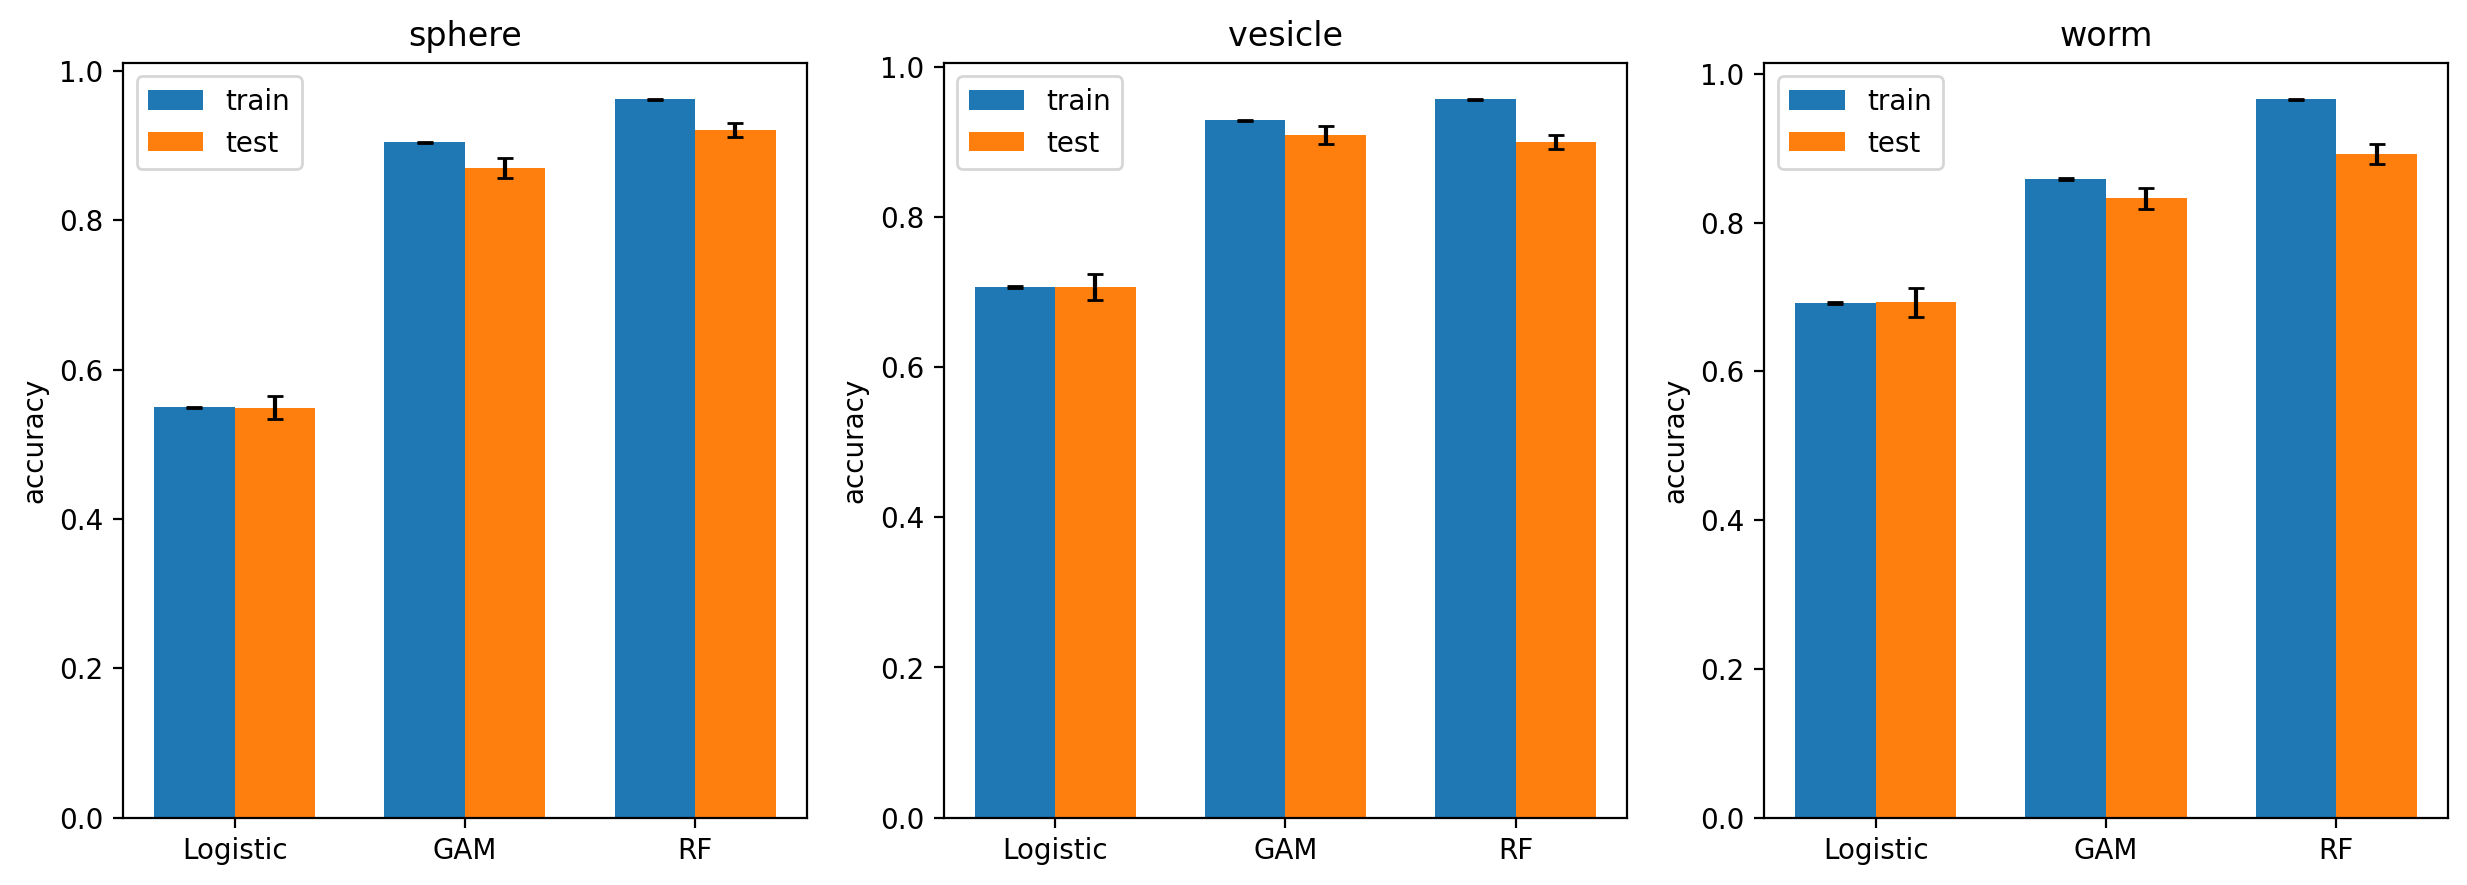

In [6]:
plt.figure(figsize=(15, 5), dpi=200)
for i, y in enumerate(['sphere', 'vesicle', 'worm']):
    plt.subplot(1, 3, i+1)
    inter_no_comp[y].plot_summary('accuracy')
    plt.title(y)

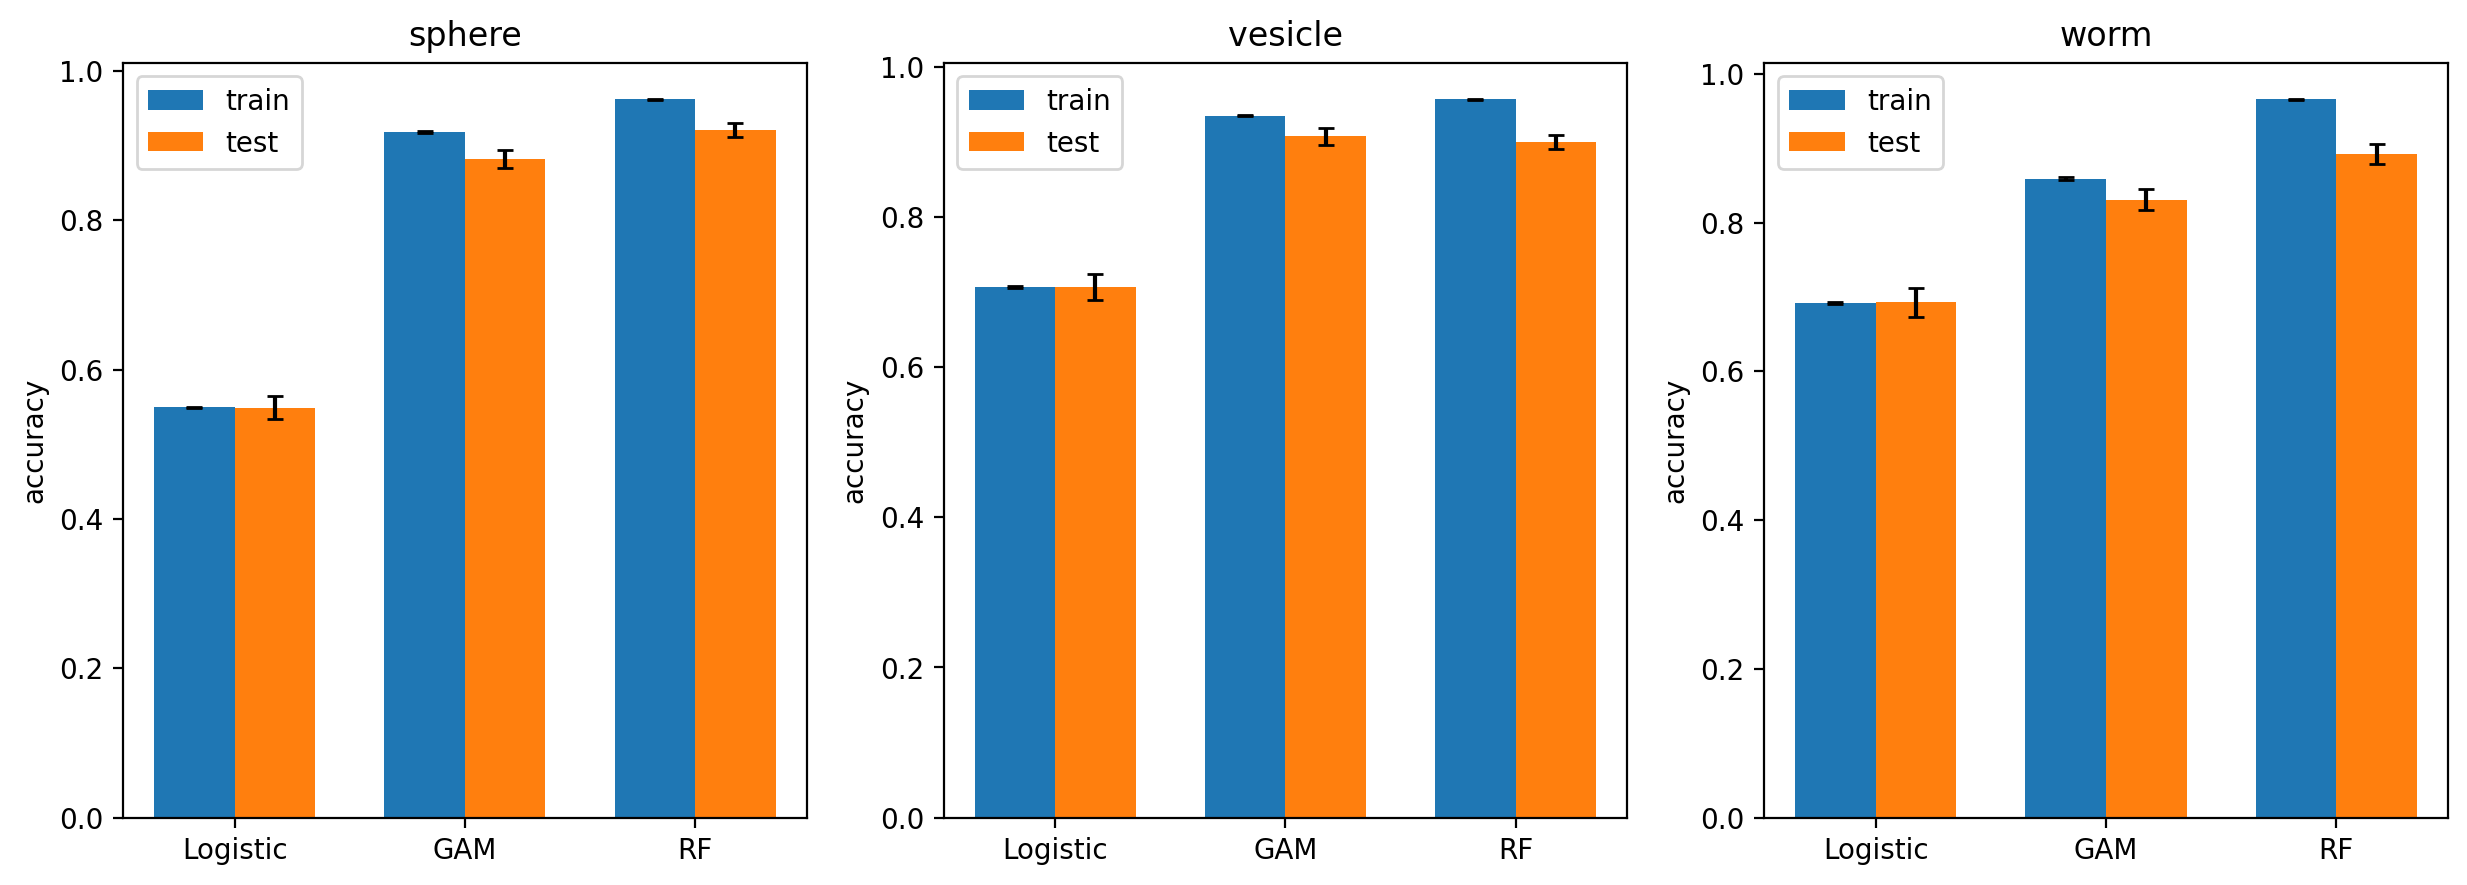

In [6]:
plt.figure(figsize=(15, 5), dpi=200)
for i, y in enumerate(['sphere', 'vesicle', 'worm']):
    plt.subplot(1, 3, i+1)
    inter_no_comp[y].plot_summary('accuracy')
    plt.title(y)

In [7]:
def overall_summary(experiments, metric='accuracy'):
    result = pd.DataFrame()
    for experiment in experiments:
        summary = experiment.summary()
        for name in experiment.estimator_names:
            result.loc[experiment.y.name, f'{name}_mean'] = summary.loc[name, f'mean_test_{metric}']
            result.loc[experiment.y.name, f'{name}_std'] = summary.loc[name, f'std_test_{metric}']
    return result

In [8]:
overall_summary(inter_no_comp.values())

,Logistic_mean,Logistic_std,GAM_mean,GAM_std,RF_mean,RF_std
sphere,0.548710,0.069593,0.881613,0.053579,0.921129,0.041906
vesicle,0.707204,0.078896,0.907903,0.050245,0.899677,0.042192
worm,0.692634,0.085898,0.830806,0.065252,0.891667,0.060471


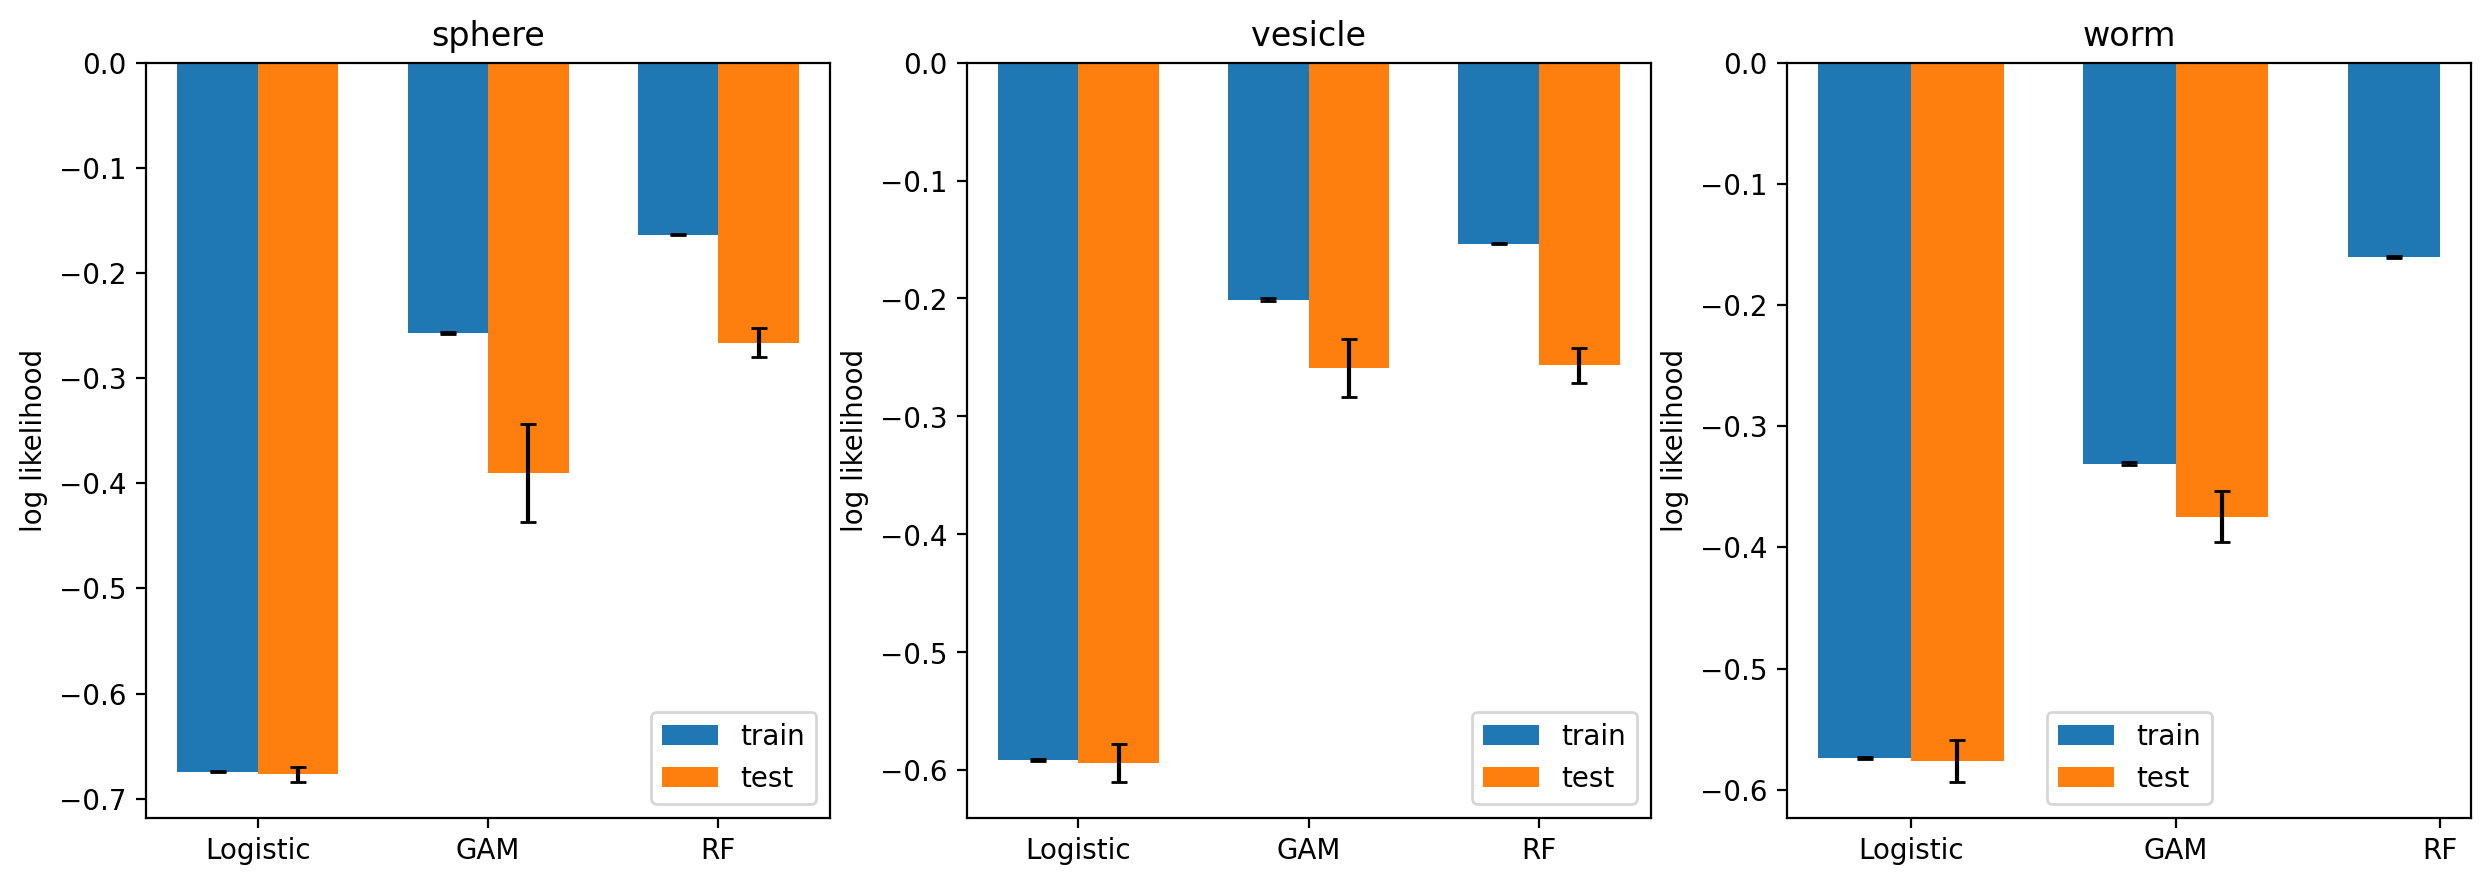

In [9]:
plt.figure(figsize=(15, 5), dpi=200)
for i, y in enumerate(['sphere', 'vesicle', 'worm']):
    plt.subplot(1, 3, i+1)
    inter_no_comp[y].plot_summary('log likelihood')
    plt.title(y)

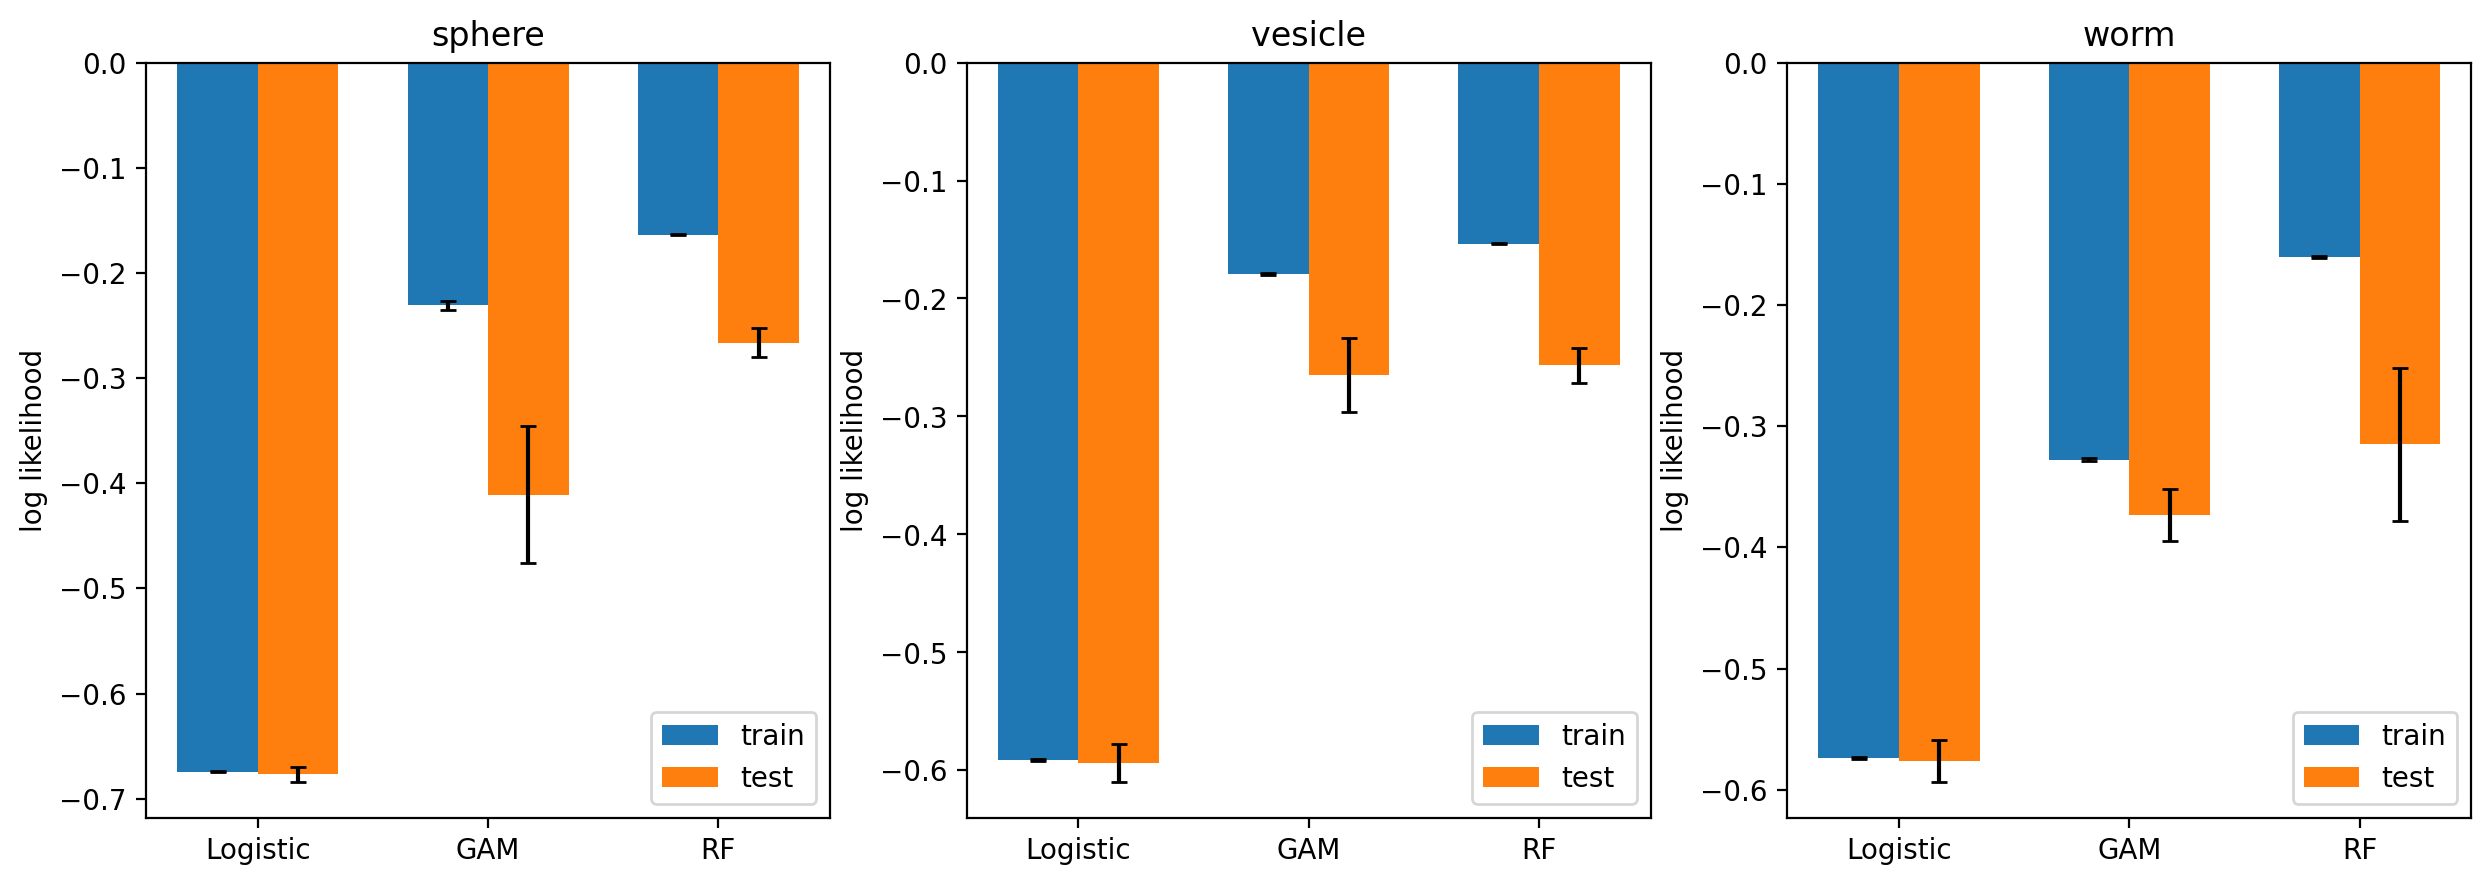

In [10]:
plt.figure(figsize=(15, 5), dpi=200)
for i, y in enumerate(['sphere', 'vesicle', 'worm']):
    plt.subplot(1, 3, i+1)
    inter_no_comp[y].plot_summary('log likelihood')
    plt.title(y)

In [11]:
overall_summary(inter_no_comp.values(), 'log likelihood')

,Logistic_mean,Logistic_std,GAM_mean,GAM_std,RF_mean,RF_std
sphere,-0.676704,0.031414,-0.410956,0.291650,-0.266424,0.061526
vesicle,-0.593747,0.070516,-0.265174,0.140106,-0.256514,0.066854
worm,-0.575907,0.077496,-0.373164,0.097014,-0.314977,0.282344


## Extrapolation performance

Next we evaluate the models when predicting phases for previously unseen monomer combinations. This is a 37-fold hold-out experiment that can take around 10 minutes (on a 2.2 GHz 6-Core Intel Core i7).

In [19]:
from sklearn.model_selection import GroupKFold

extra_no_comp = {}

for y in [data.sphere, data.vesicle, data.worm]:
    print('Target: ', y.name)
    experiment = Experiment(estimators[y.name], 
                        names,
                        GroupKFold(37),
                        data.x.filter(data.predictors, axis=1), y.replace(-1.0, 0.0), data.comp_ids.array, 
                        evaluators=['accuracy', LogLikelihoodEvaluator()],
                        verbose=True)
    extra_no_comp[y.name] = experiment.run()
    print()

Target:  sphere
Running experiment with 37 repetitions
*************************************

Target:  vesicle
Running experiment with 37 repetitions
did not converge
*************************************

Target:  worm
Running experiment with 37 repetitions
*************************************



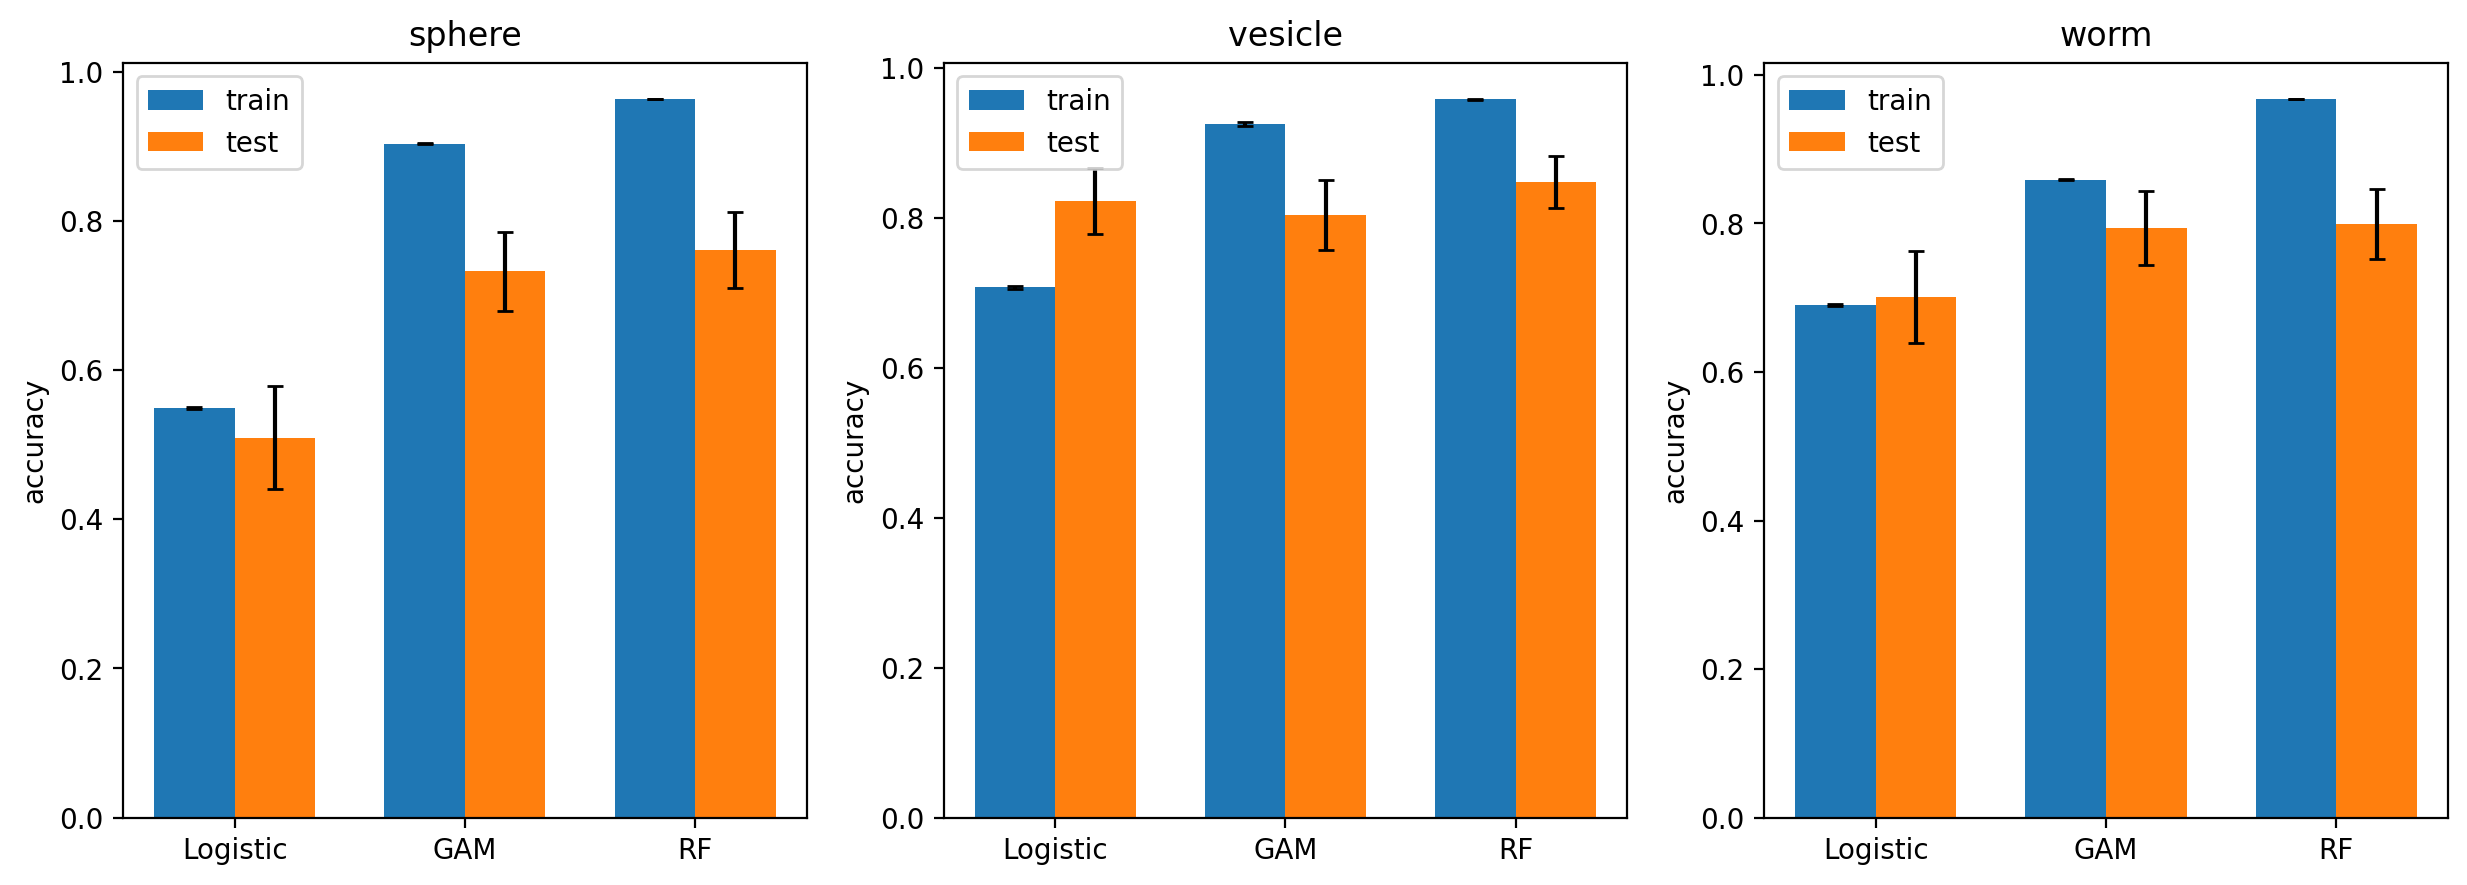

In [13]:
plt.figure(figsize=(15, 5), dpi=200)
for i, y in enumerate(['sphere', 'vesicle', 'worm']):
    plt.subplot(1, 3, i+1)
    extra_no_comp[y].plot_summary('accuracy')
    plt.title(y)
plt.show()

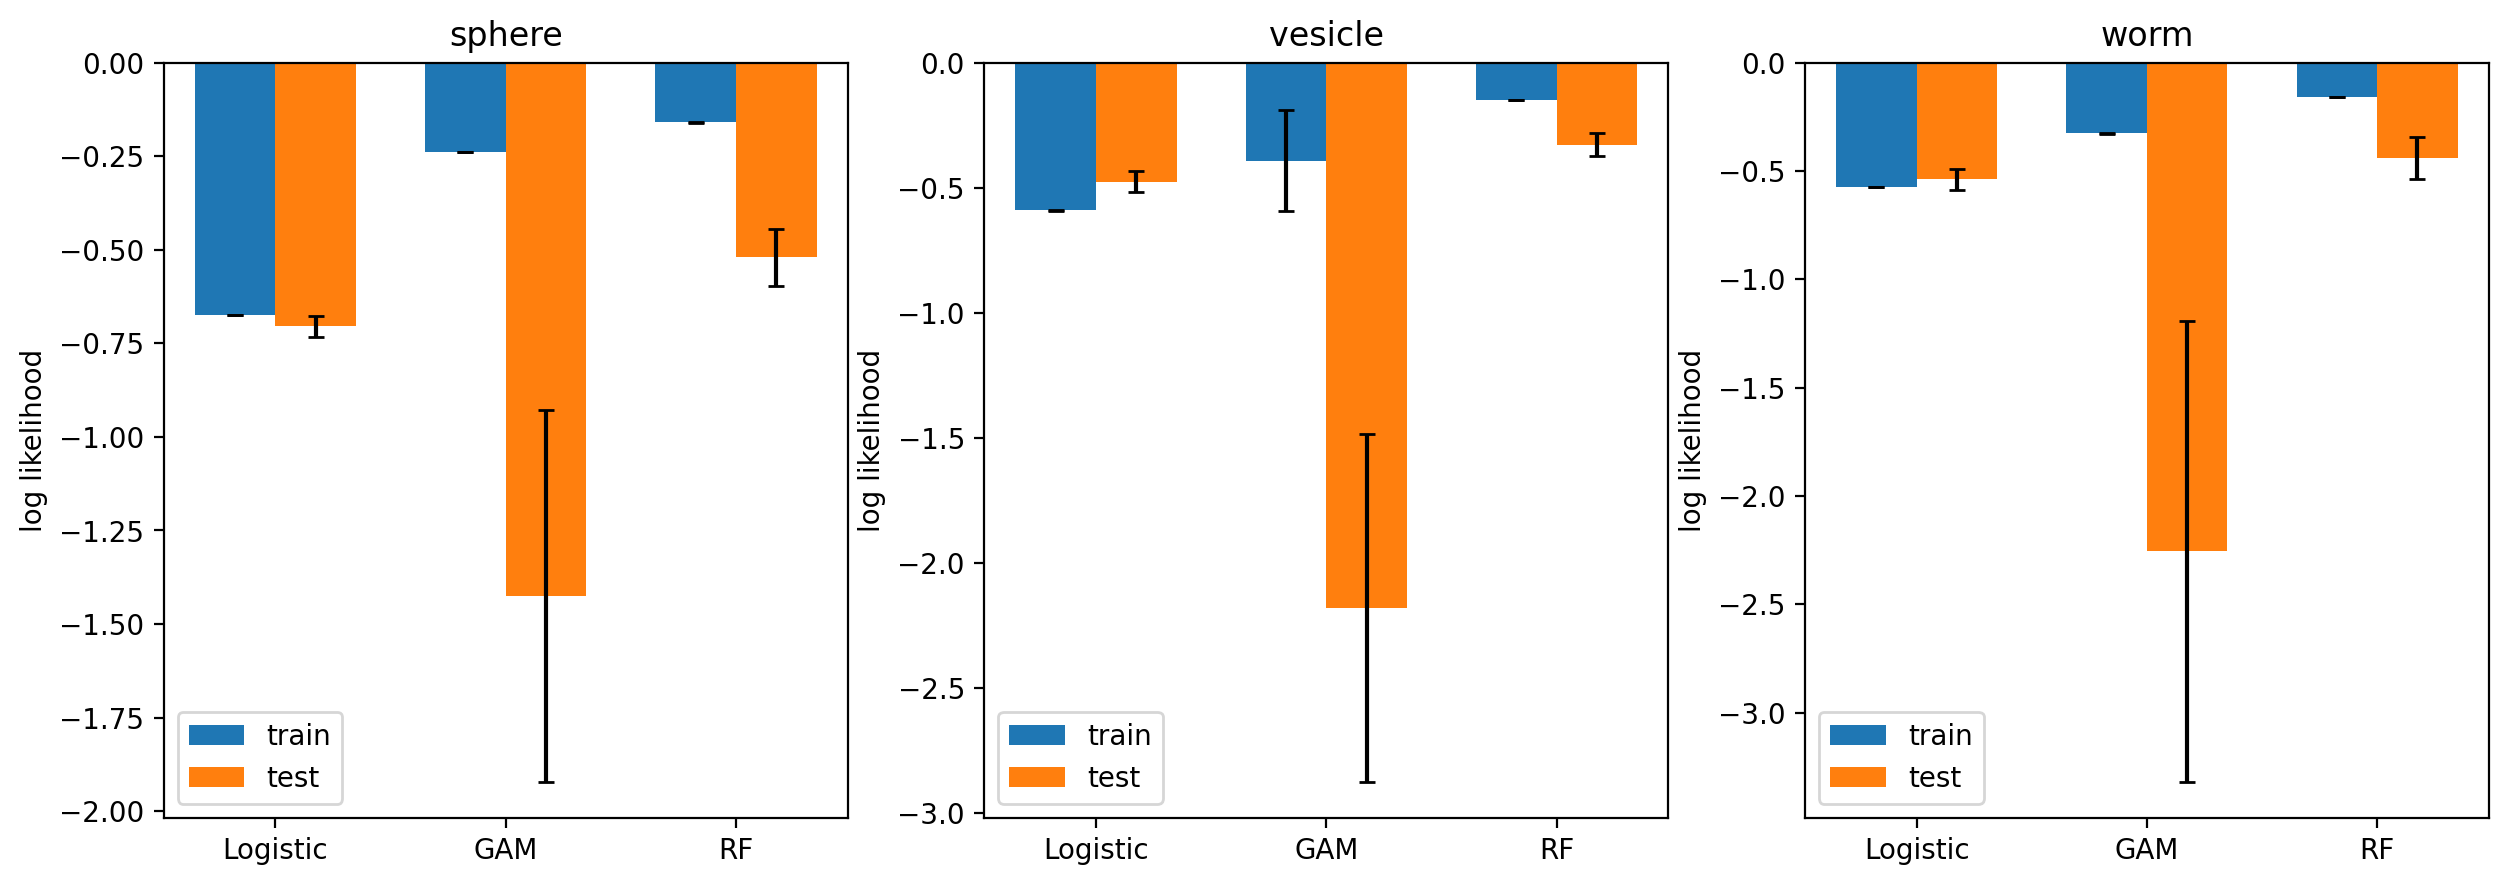

In [20]:
plt.figure(figsize=(15, 5), dpi=200)
for i, y in enumerate(['sphere', 'vesicle', 'worm']):
    plt.subplot(1, 3, i+1)
    extra_no_comp[y].plot_summary('log likelihood')
    plt.title(y)
plt.show()

In [10]:
overall_summary(extra_no_comp.values())

,Logistic_mean,Logistic_std,GAM_mean,GAM_std,RF_mean,RF_std
sphere,0.509572,0.422963,0.732700,0.320869,0.754973,0.330888
vesicle,0.822437,0.267549,0.803365,0.281259,0.847066,0.222109
worm,0.701124,0.377077,0.794235,0.303035,0.790882,0.293998


In [22]:
overall_summary(extra_no_comp.values(), metric='log likelihood')

,Logistic_mean,Logistic_std,GAM_mean,GAM_std,RF_mean,RF_std
sphere,-0.704955,0.175891,-1.425028,3.016279,-0.520509,0.457820
vesicle,-0.475870,0.259916,-2.180881,4.225993,-0.327761,0.283473
worm,-0.537897,0.297265,-2.254683,6.470992,-0.439612,0.583445
